In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from common.utils import*
from common.networks import*


### LOAD DATA

In [2]:
mat = scipy.io.loadmat('./binaryalphadigs.mat')
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(1)]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(39, 320)


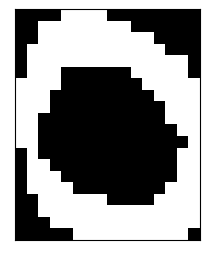

In [3]:
plt.figure(figsize=(3,3))
plt.xticks([])
plt.yticks([])
plt.imshow(test[0].reshape(20,16),cmap='gray')

# Test RBM - ALPHADigits

### First on one digit

**We will train the rbm for 1000 epochs and a batch size of 15 and perform only one gibbs sampling**

In [4]:
input_size = test.shape[1]
hidden_size = 100
rbm = RBM(input_size,hidden_size,device)
digits_test = torch.tensor(test).float().to(device) # convert to tensor
rbm.train(data=digits_test,n_steps=1000,alpha=0.1,batch_size=15,k=1) 

**Now we test if we can reconstruct an image**

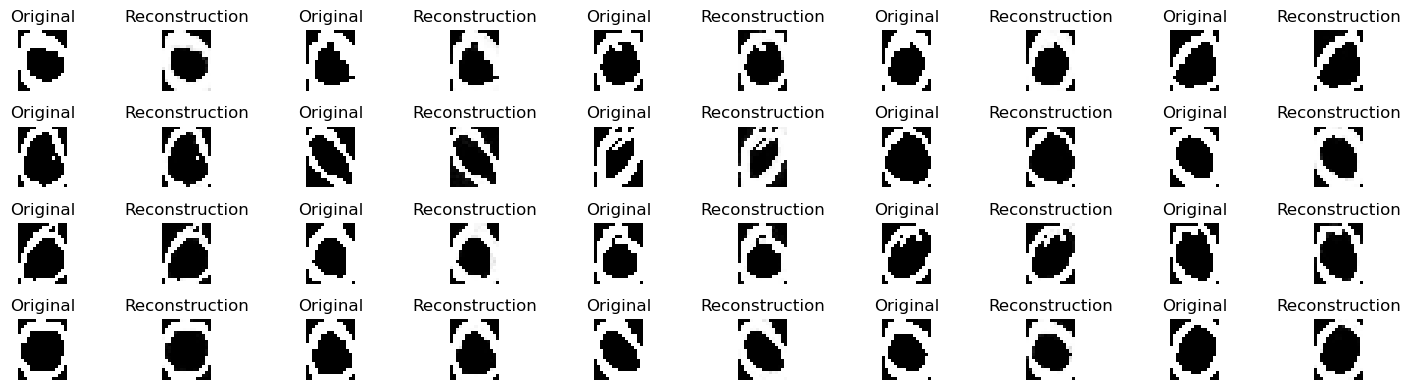

In [5]:
nums = 20
idxs = np.random.choice(test.shape[0], size=nums, replace=False)
pics = torch.tensor(test[idxs]).float().to(device)
b = rbm.forward(pics) 
p = rbm.backward(b)
# Ajuster la taille de la figure pour mieux s'adapter à une ligne
plt.figure(figsize=(15,nums//5))  # Ajuster la taille de la figure pour mieux s'adapter aux images
for i in range(nums):
    # Image originale
    plt.subplot(nums//5, 10, 2*i+1)  # num_rows lignes, 2*nums colonnes, position actuelle
    plt.imshow(pics[i].detach().cpu().numpy().reshape(20,16), cmap='gray')
    plt.title("Original")
    plt.axis('off') 
    # Image reconstruite
    plt.subplot(nums//5, 10, 2*i+2)  # num_rows lignes, 2*nums colonnes, position actuelle + 1
    plt.imshow(p[i].detach().cpu().numpy().reshape(20,16), cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
latent = rbm.forward(digits_test) 
reconstructed = rbm.backward(latent)
Reconstruction_error = calculate_mse(digits_test.detach().cpu().numpy(),reconstructed.detach().cpu().numpy())
print("Reconstruction error :", Reconstruction_error)

Reconstruction error : 0.00029136302


**Perfect we were able to reconstruct an image. Now we will test the generation performance**

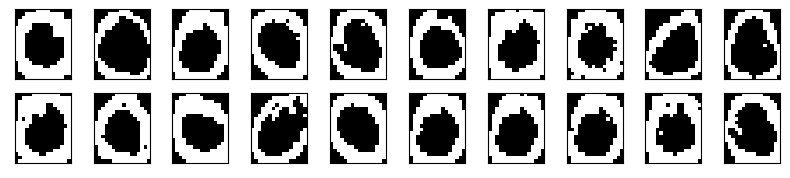

In [7]:
gen = rbm.generate(20,100) # we generate 20 images and perform 100 gibbs sampling
plt.figure(figsize=(10,2))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(gen[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([]),plt.yticks([])

**For now our model can reconstruct and generate samples for digit 0. Now we will test with more digits**

### With 10 digits

In [8]:
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(10)]
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(390, 320)


In [9]:
input_size = test.shape[1]
hidden_size = 300
rbm = RBM(input_size,hidden_size,device)
digits_test = torch.tensor(test).float().to(device) # convert to tensor
rbm.train(data=digits_test,n_steps=5000,alpha=0.1,batch_size=64,k=1) 

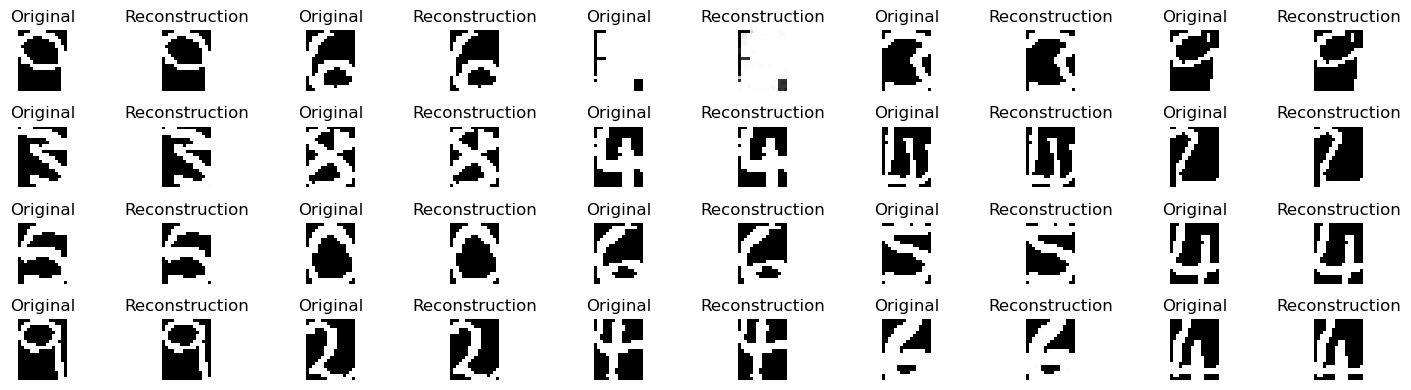

In [10]:
nums = 20
idxs = np.random.choice(test.shape[0], size=nums, replace=False)
pics = torch.tensor(test[idxs]).float().to(device)
b = rbm.forward(pics) 
p = rbm.backward(b)
# Ajuster la taille de la figure pour mieux s'adapter à une ligne
plt.figure(figsize=(15,nums//5))  # Ajuster la taille de la figure pour mieux s'adapter aux images
for i in range(nums):
    # Image originale
    plt.subplot(nums//5, 10, 2*i+1)  # num_rows lignes, 2*nums colonnes, position actuelle
    plt.imshow(pics[i].detach().cpu().numpy().reshape(20,16), cmap='gray')
    plt.title("Original")
    plt.axis('off') 
    # Image reconstruite
    plt.subplot(nums//5, 10, 2*i+2)  # num_rows lignes, 2*nums colonnes, position actuelle + 1
    plt.imshow(p[i].detach().cpu().numpy().reshape(20,16), cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
latent = rbm.forward(digits_test)
reconstructed = rbm.backward(latent)
Reconstruction_error = calculate_mse(digits_test.detach().cpu().numpy(),reconstructed.detach().cpu().numpy())
print("Reconstruction error :", Reconstruction_error)

Reconstruction error : 5.552654e-05


**We are able to reconstruct digits**

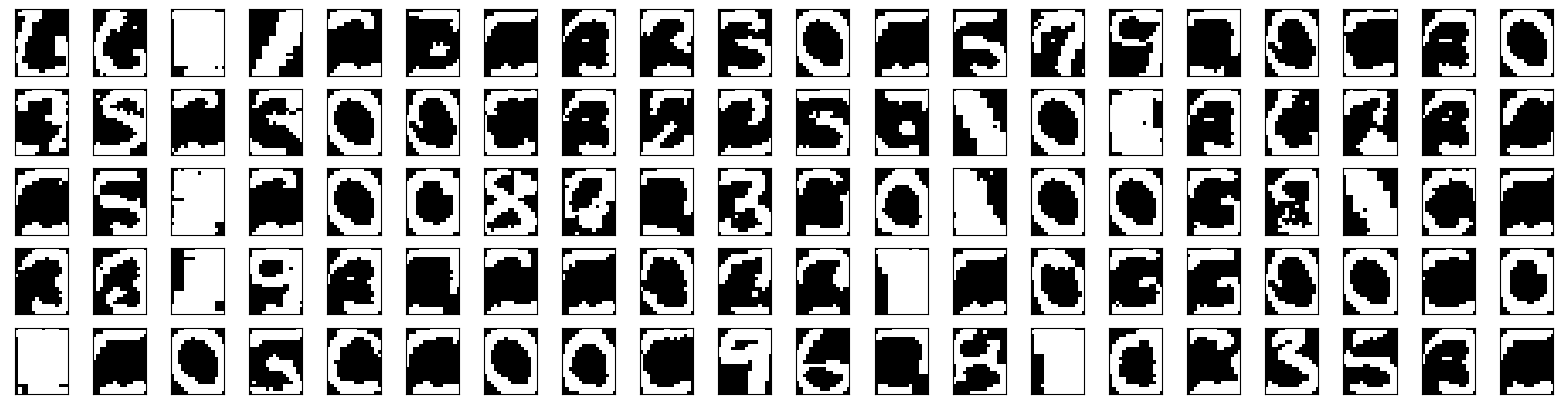

In [12]:
gen = rbm.generate(100,1000) # we generate 100 images and perform 1000 gibbs sampling
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(gen[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([]),plt.yticks([])

**The digit 0 is being well generated .The digit 1 less and the digit 2 not  well**

Now will test the DBN

# TEST DBN ALPHADigits

In [13]:
arrays_list = [ lire_alpha(mat['dat'],i) for i in range(5)] # we charge all the digits
test = np.concatenate(arrays_list, axis=0)
np.random.shuffle(test)
print(test.shape)

(195, 320)


In [14]:
# init the DBN with 3 layers 
hidden_sizes = [300,300,300]
input_size = test.shape[1]
dbn = DBN(input_size,hidden_sizes,device)
digits_test = torch.tensor(test).float().to(device)
# we train for 5000 epochs with a batchsize of 128 and perform 1 gibbs sampling
dbn.train(data=digits_test,n_steps=5000,alpha=1e-1,batch_size=128,k=1)

100%|██████████| 3/3 [00:25<00:00,  8.49s/it]


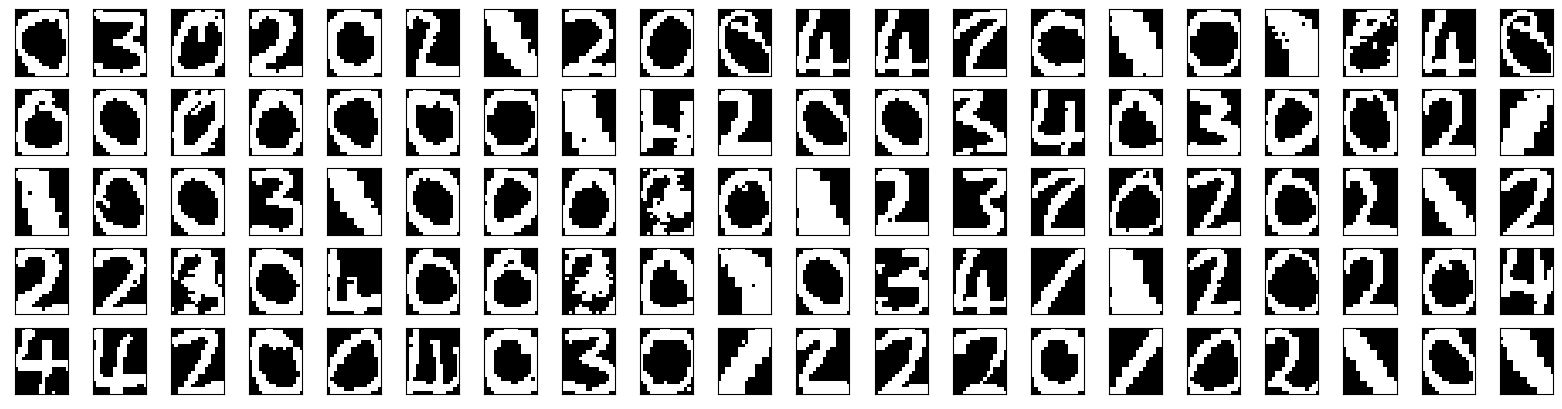

In [15]:
gen2 = dbn.generate(100,1000) # we generate 100 samples and perform 100 gibbs sampling
plt.figure(figsize=(20,5))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(gen2[i].detach().cpu().numpy().reshape(20,16),cmap='gray')
    plt.xticks([])
    plt.yticks([])

**The digits are more well generated with a DBN**

# TEST DNN - MNIST

In [17]:
# Create a DataLoader
train_dataset,test_dataset = load_mnist(40000) # first we load 40000 images from the data
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,collate_fn=one_hot_collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=one_hot_collate)

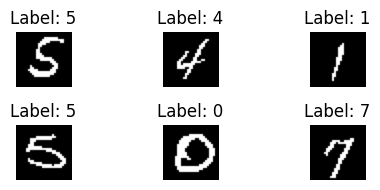

In [18]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5, 2))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze() #
    ax.imshow(img.reshape(28,28), cmap='gray') 
    ax.set_title(f'Label: {labels[i].argmax().item()}') 
    ax.axis('off') 

plt.tight_layout() # Ajuster automatiquement les sous-plots pour qu'ils s'insèrent dans la figure
plt.show()

### Pretraining

In [19]:
pretrain_set = [train_dataset.dataset[i][0] for i in train_dataset.indices]

In [20]:
hidden_sizes = [1000,1000]
num_classes = 10
input_size = 784
model = DNN(input_size,hidden_sizes,num_classes,device)
digits_test = torch.stack(pretrain_set).float().to(device)
model.pretrain(digits_test,n_steps=100,alpha=1e-3,batch_size=128,k=1) # we pretrain the DNN  for 1000 epochs and a batch of 128

100%|██████████| 2/2 [02:24<00:00, 72.34s/it]


**Now we train the DNN on a supervised manner for 50 epochs**

In [21]:
model = model.to(device)
model.train(dataloader=train_loader,n_epochs=30,lr=1e-4)

100%|██████████| 30/30 [05:28<00:00, 10.96s/it]


In [22]:
model.evaluate(test_loader) # we evaluate on the test

0.9724